In [1]:
import numpy as np
import os, sys
import pandas as pd
import scipy.stats
import scipy.io as spio


# root directory is 2 dirs up from this file
# path = os.path.realpath(__file__).split('/')
# root = '/'+os.path.join(*path[0:-3])
root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))


import matplotlib.pyplot as plt

from code_utils import data_utils, file_utils

In [2]:
subjects = np.arange(1,8)

make_time_resolved = True
use_bigIPS = True
concat_IPS = True;

# first load all data for all subjects, both tasks
maindat_all = []; 
repdat_all = []
mainlabs_all = []; 
replabs_all = []

maindat_avg = []; 
repdat_avg = []

for si, ss in enumerate(subjects):

    print('loading S%02d, main task'%ss)
    main_data_avg, main_data_by_tr, main_labels, roi_names = data_utils.load_main_task_data(ss, make_time_resolved, \
                                                                                use_bigIPS, concat_IPS)

    maindat_all += [main_data_by_tr]
    maindat_avg += [main_data_avg]
    
    mainlabs_all += [main_labels]

    print('loading S%02d, repeat task'%ss)
    rep_data_avg, rep_data_by_tr, rep_labels, roi_names = data_utils.load_repeat_task_data(ss, make_time_resolved, \
                                                                                use_bigIPS, concat_IPS)


    repdat_all += [rep_data_by_tr]
    repdat_avg += [rep_data_avg]
    replabs_all += [rep_labels]

loading S01, main task
loading S01, repeat task
loading S02, main task
loading S02, repeat task
loading S03, main task
loading S03, repeat task
loading S04, main task
loading S04, repeat task
loading S05, main task
loading S05, repeat task
loading S06, main task
loading S06, repeat task
loading S07, main task
loading S07, repeat task


In [76]:
main_data_avg[0].shape

(1728, 1520)

In [3]:
from matplotlib import cm
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat (one-back)'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:5,:])


In [4]:
nTRs_concat = 14;
time_axis = np.arange(0,nTRs_concat) * 0.8

In [5]:
avgTRs_targ = [4,7];
# avgTRs_targ = [3,7];

In [77]:
n_subjects = len(subjects)
n_rois = len(roi_names)


In [113]:
trial_group_names = ['easy','hard']
n_trial_groups = 2;
n_timepts = 14
trial_group_means = np.zeros((n_subjects, n_rois, n_tasks-1, n_trial_groups, n_timepts))

for si in range(n_subjects):
    
    for ri in range(n_rois):
    
        for ti, task_ind in enumerate([1,2,3]):
 
            tasklabs = np.array(mainlabs_all[si]['task'])
            is_main_grid = np.array(mainlabs_all[si]['is_main_grid']==1)
            dist = np.array(mainlabs_all[si]['dist_from_bound%d'%task_ind]).round(2)

            inds1 = (tasklabs==task_ind) & is_main_grid
            inds2 = (tasklabs==task_ind) &  ~is_main_grid
                
            # print(np.sum(inds1), np.sum(inds2), np.sum(inds3))

            assert(np.sum(inds1)+np.sum(inds2)==np.sum(tasklabs==task_ind))

            d1 = np.mean(np.mean(maindat_all[si][ri][inds1,:,:], axis=0), axis=1)
            
            trial_group_means[si,ri,ti,0,:] = d1
            
            d2 = np.mean(np.mean(maindat_all[si][ri][inds2,:,:], axis=0), axis=1)
            
            trial_group_means[si,ri,ti,1,:] = d2
 

In [114]:
from code_utils import stats_utils

pvals_comparegroups = np.zeros((n_rois, n_tasks-1, 1, n_timepts))

rndseed = 4354564
for ri in range(n_rois):

    for ti, task_ind in enumerate([1,2,3]):
        
        for tpti in range(n_timepts):
        
            dat1 = trial_group_means[:,ri,ti,0,tpti]
            dat2 = trial_group_means[:,ri,ti,1,tpti]
            
            p,t = stats_utils.paired_ttest_nonpar(dat1, dat2, \
                                           n_iter=1000, \
                                                  # n_iter=2, \
                                                  rndseed=rndseed)    
        
            pvals_comparegroups[ri,ti,0,tpti] = p

In [121]:
from code_utils import plot_utils
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

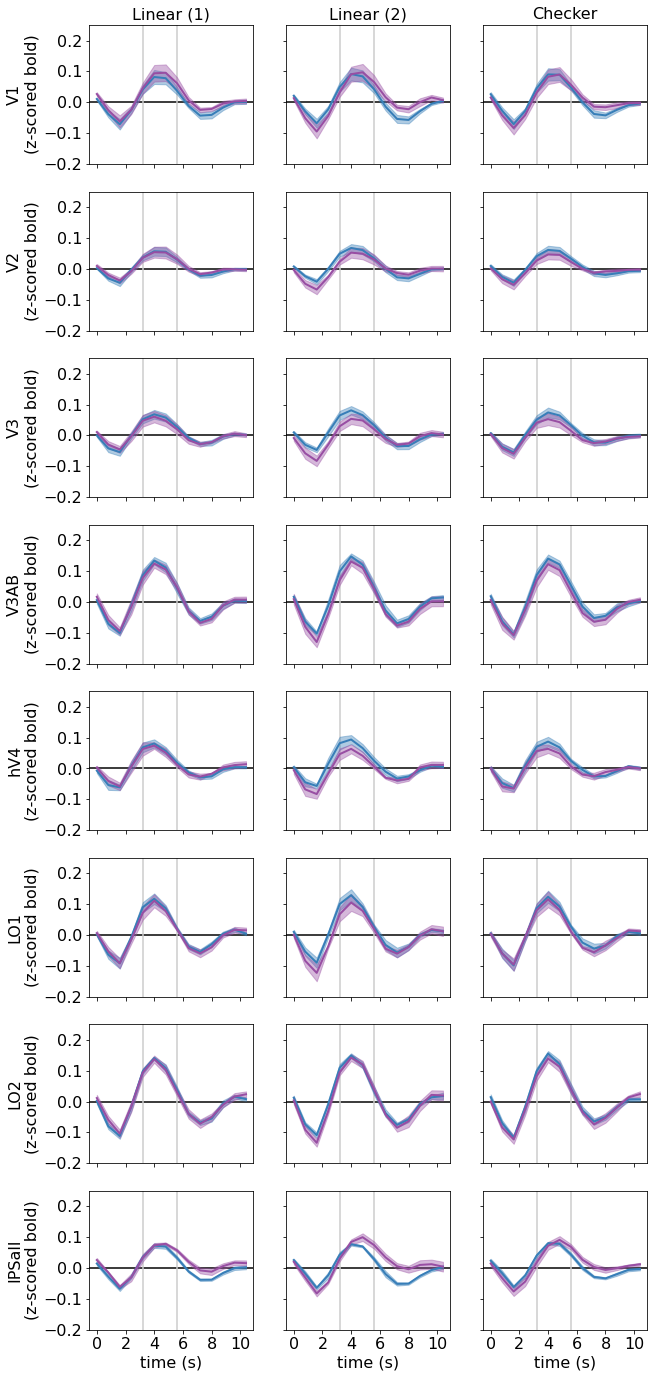

In [126]:
plt.figure(figsize=(10,24))

colors = cm.Set1(np.linspace(0,1,9))[[1,3],:]

p_thresh = 0.05

sig_height_plot = 0.21

n_rois = len(roi_names)

pi = 0;
# for ri in range(1):
for ri in range(n_rois):
    
    for ti, task_ind in enumerate([1,2,3]):
         
        pi+=1
        plt.subplot(n_rois,3,pi)
        
        # for tgi in [0]:
        for tgi in [0,1]:
            dat = trial_group_means[:,ri,ti,tgi,:]
        
            # then average over subjects
            meanvals = np.mean(dat, axis=0)
            semvals = np.std(dat, axis=0)/np.sqrt(n_subjects)
            
            plt.plot(time_axis, meanvals, color=colors[tgi, :], lw = 2)
            # plt.errorbar(time_axis, meanvals, semvals, color=colors[tgi,:])
            plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[tgi,:], alpha=0.40)
            
        sig_diffs = pvals_comparegroups[ri,ti,0,:] < p_thresh
        for tpti in np.where(sig_diffs)[0]:
            plt.plot(time_axis[tpti], sig_height_plot, '.', color=[0.5, 0.5, 0.5])
            
        plt.ylim([-0.15, 0.25])
        plt.axhline(0, color='k', zorder=-10)

        plt.axvline(time_axis[avgTRs_targ[0]], color=[0.8, 0.8, 0.8], zorder=-10)
        plt.axvline(time_axis[avgTRs_targ[1]], color=[0.8, 0.8, 0.8], zorder=-10)
        # plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[tgi,:], alpha=0.40)
            
        if ri==0:
            plt.title(task_names[ti])
        
        if ri==(n_rois-1):
            plt.xlabel('time (s)')
            plt.xticks(np.arange(0,12,2))
        else:
            plt.xticks(np.arange(0,12,2), [])

        if ti==0:
            plt.ylabel('%s\n(z-scored bold)'%roi_names[ri])
            plt.yticks(np.arange(-0.2, 0.3, 0.1))
        else:
            plt.yticks(np.arange(-0.2, 0.3, 0.1), [])
            
        
        figname = os.path.join(figfolder, 'easyvshard_allrois.pdf')
        plt.savefig(figname)

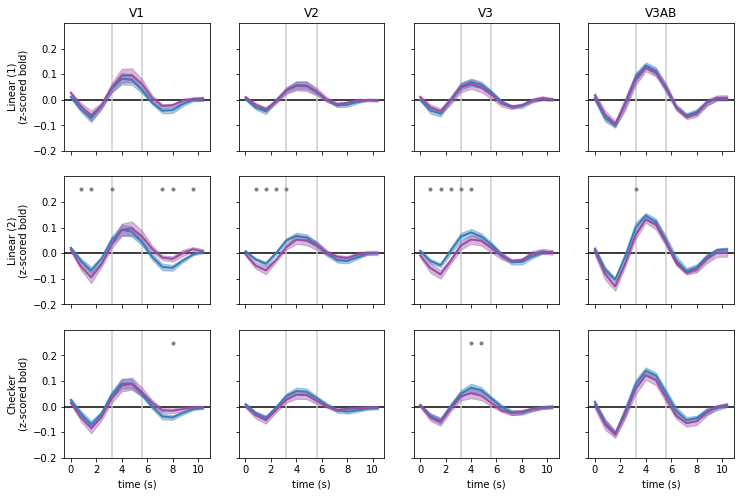

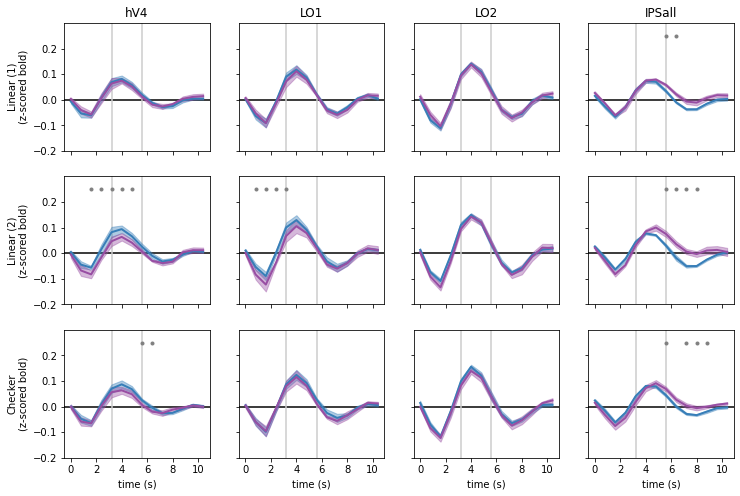

In [119]:
rois1 = [0,1,2,3]
rois2 = [4,5,6,7]

for fi, rois in enumerate([rois1, rois2]):

    plt.figure(figsize=(12,8))

    colors = cm.Set1(np.linspace(0,1,9))[[1,3],:]

    p_thresh = 0.05
    sig_height_plot = 0.25

    n_rois = len(roi_names)

    pi = 0;
    for ti, task_ind in enumerate([1,2,3]):

        # for ri in range(1):
        for ri, rr in enumerate(rois):


            pi+=1
            plt.subplot(3, len(rois), pi)

            # for tgi in [0]:
            for tgi in [0,1]:
                dat = trial_group_means[:,rr,ti,tgi,:]

                # then average over subjects
                meanvals = np.mean(dat, axis=0)
                semvals = np.std(dat, axis=0)/np.sqrt(n_subjects)

                plt.plot(time_axis, meanvals, color=colors[tgi, :], lw = 2)
                # plt.errorbar(time_axis, meanvals, semvals, color=colors[tgi,:])
                plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[tgi,:], alpha=0.40)

            sig_diffs = pvals_comparegroups[rr,ti,0,:] < p_thresh
            for tpti in np.where(sig_diffs)[0]:
                plt.plot(time_axis[tpti], sig_height_plot, '.', color=[0.5, 0.5, 0.5])

            plt.ylim([-0.2, 0.3])
            plt.axhline(0, color='k', zorder=-10)

            plt.axvline(time_axis[avgTRs_targ[0]], color=[0.8, 0.8, 0.8], zorder=-10)
            plt.axvline(time_axis[avgTRs_targ[1]], color=[0.8, 0.8, 0.8], zorder=-10)
            # plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[tgi,:], alpha=0.40)

            if ti==0:
                plt.title(roi_names[rr])

            if ti==(2):
                plt.xlabel('time (s)')
                plt.xticks(np.arange(0,12,2))
            else:
                plt.xticks(np.arange(0,12,2), [])

            if ri==0:
                plt.ylabel('%s\n(z-scored bold)'%task_names[ti])
                plt.yticks(np.arange(-0.2, 0.3, 0.1))
            else:
                plt.yticks(np.arange(-0.2, 0.3, 0.1), [])

        

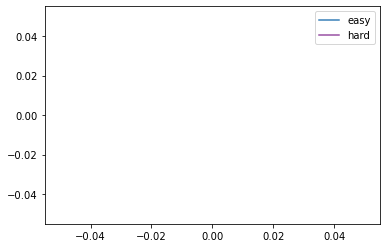

In [65]:
plt.figure()
for ii in range(2):
    plt.plot(0,0, color=colors[ii])
plt.legend(trial_group_names)

In [89]:
from code_utils import stats_utils

task_pairs = [[0,1],[0,2],[1,2]]
n_pairs = len(task_pairs)
pvals_comparegroups = np.zeros((n_rois, n_trial_groups, n_pairs, n_timepts))

rndseed = 223454
for ri in range(n_rois):

    for tgi in [0,1]:
        
        for pi, pair in enumerate(task_pairs):
          
            for tpti in range(n_timepts):

                dat1 = trial_group_means[:,ri,pair[0],tgi,tpti]
                dat2 = trial_group_means[:,ri,pair[1],tgi,tpti]

                p,t = stats_utils.paired_ttest_nonpar(dat1, dat2, \
                                                      n_iter=1000, \
                                                      # n_iter=2, \
                                                      rndseed=rndseed)    

                pvals_comparegroups[ri,tgi,pi,tpti] = p

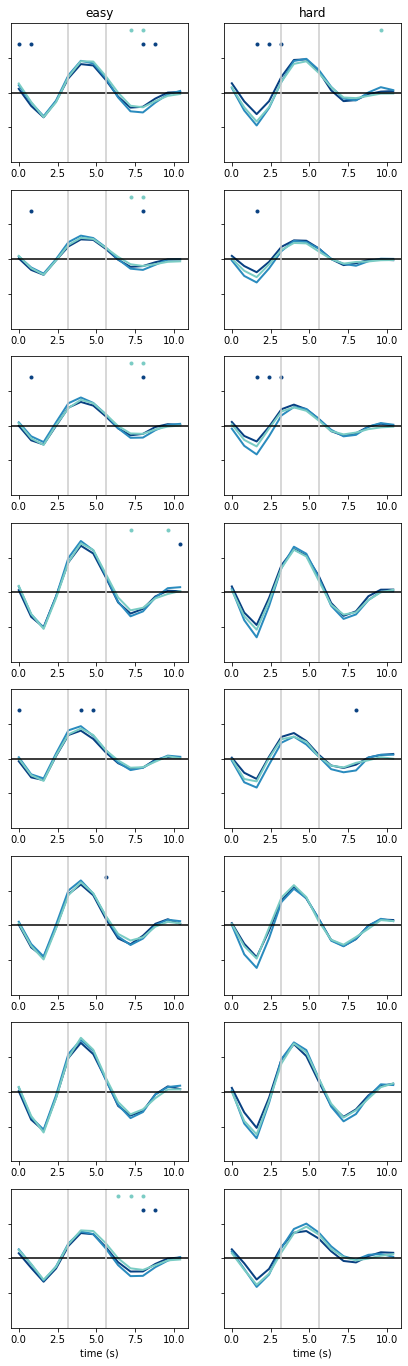

In [91]:
plt.figure(figsize=(7,24))

colors = task_colors[0:3,:]

p_thresh = 0.05
sig_heights_plot = [0.14, 0.16, 0.18]

n_rois = len(roi_names)

pi = 0;
# for ri in range(1):
for ri in range(n_rois):
    
    for tgi in [0,1]:
         
        pi+=1
        plt.subplot(n_rois,2,pi)
        
        # for tgi in [0]:
        for ti in [0,1,2]:
            dat = trial_group_means[:,ri,ti,tgi,:]
        
            # then average over subjects
            meanvals = np.mean(dat, axis=0)
            semvals = np.std(dat, axis=0)/np.sqrt(n_subjects)
            
            plt.plot(time_axis, meanvals, color=colors[ti, :], lw = 2)
            # plt.errorbar(time_axis, meanvals, semvals, color=colors[tgi,:])
            # plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[ti,:], alpha=0.40)
         
        for pai in range(n_pairs):
            sig_diffs = pvals_comparegroups[ri,tgi,pai,:] < p_thresh
            for tpti in np.where(sig_diffs)[0]:
                plt.plot(time_axis[tpti], sig_heights_plot[pai], '.', color=colors[pai,:])
            
        plt.ylim([-0.2, 0.2])
        plt.axhline(0, color='k')

        plt.axvline(time_axis[avgTRs_targ[0]], color=[0.8, 0.8, 0.8])
        plt.axvline(time_axis[avgTRs_targ[1]], color=[0.8, 0.8, 0.8])

        if ri==0:
            plt.title(trial_group_names[tgi])
        
        if ri==(n_rois-1):
            plt.xlabel('time (s)')

        if ti==0:
            plt.ylabel('%s\n(z-scored bold)'%roi_names[ri])
            plt.yticks([-0.1, 0, 0.1])
        else:
            plt.yticks([-0.1, 0, 0.1], [])
        

In [94]:
trial_group_names = ['easy', 'med', 'hard']
n_trial_groups = 3;
n_timepts = 14
trial_group_means = np.zeros((n_subjects, n_rois, n_tasks-1, n_trial_groups, n_timepts))

dat1 = []
dat2 = []
dat3 = []

for si in range(n_subjects):
    
    for ri in range(n_rois):
    
        for ti, task_ind in enumerate([1,2,3]):
 
            tasklabs = np.array(mainlabs_all[si]['task'])
            is_main_grid = np.array(mainlabs_all[si]['is_main_grid']==1)
            dist = np.array(mainlabs_all[si]['dist_from_bound%d'%task_ind]).round(2)

            inds1 = (tasklabs==task_ind) & is_main_grid & (dist==2.4)
            inds2 = (tasklabs==task_ind) & is_main_grid & (dist==0.8)
            inds3 = (tasklabs==task_ind) & ~is_main_grid
                
            # print(np.sum(inds1), np.sum(inds2), np.sum(inds3))

            assert(np.sum(inds1)+np.sum(inds2)+np.sum(inds3)==np.sum(tasklabs==task_ind))

            d1 = np.mean(np.mean(maindat_all[si][ri][inds1,:,:], axis=0), axis=1)
            
            trial_group_means[si,ri,ti,0,:] = d1
            
            d2 = np.mean(np.mean(maindat_all[si][ri][inds2,:,:], axis=0), axis=1)
            
            trial_group_means[si,ri,ti,1,:] = d2
            
            d3 = np.mean(np.mean(maindat_all[si][ri][inds3,:,:], axis=0), axis=1)
            
            trial_group_means[si,ri,ti,2,:] = d3
            

In [95]:
from code_utils import stats_utils

pvals_comparegroups = np.zeros((n_rois, n_tasks-1, 3, n_timepts))
pairs_compare = [[0,1],[0,2],[1,2]]

rndseed = 343434
for ri in range(n_rois):

    for ti, task_ind in enumerate([1,2,3]):
        
        for pi, pair in enumerate(pairs_compare):

            for tpti in range(n_timepts):

                dat1 = trial_group_means[:,ri,ti,pair[0],tpti]
                dat2 = trial_group_means[:,ri,ti,pair[1],tpti]

                p,t = stats_utils.paired_ttest_nonpar(dat1, dat2, \
                                                      n_iter=1000, \
                                                      # n_iter=2, \
                                                      rndseed=rndseed)    

                pvals_comparegroups[ri,ti,pi,tpti] = p

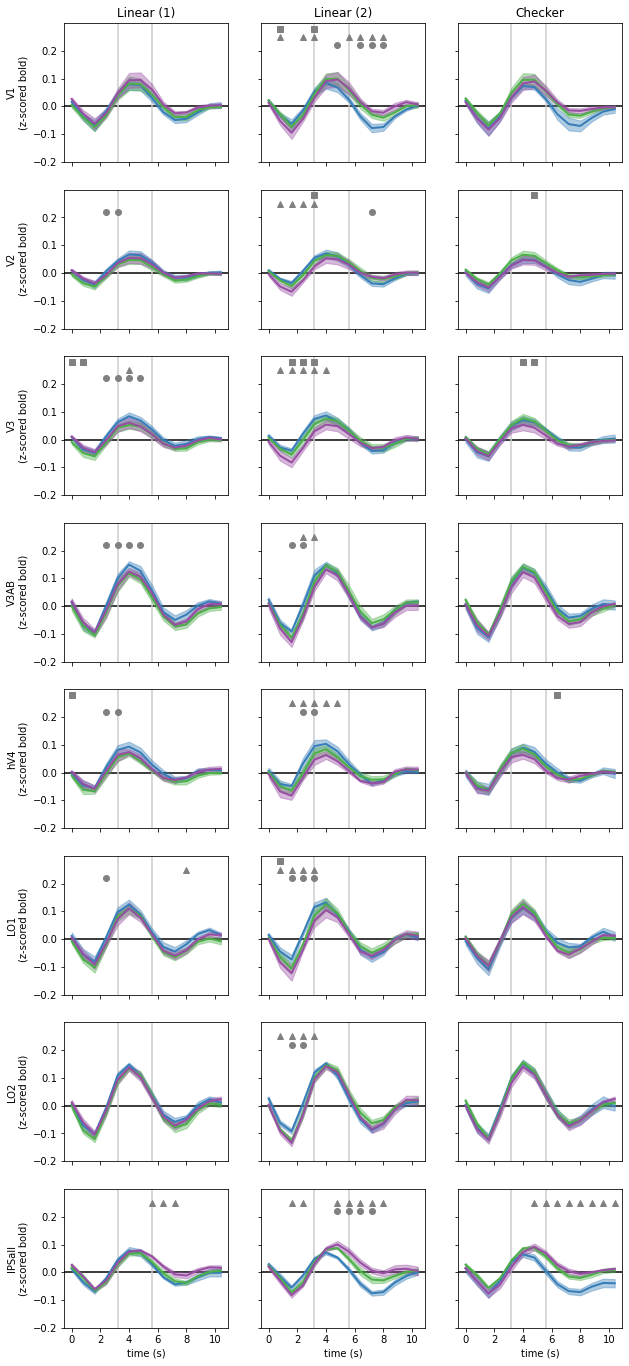

In [112]:
plt.figure(figsize=(10,24))

colors = cm.Set1(np.linspace(0,1,9))[[1,2,3],:]
sig_heights_plot = np.linspace(0.22, 0.28, 3)
# sig_heights_plot = [0.14, 0.16, 0.18]
sig_shapes = ['o','^','s']
p_thresh = 0.05

n_rois = len(roi_names)

pi = 0;
# for ri in range(1):
for ri in range(n_rois):
    
    for ti, task_ind in enumerate([1,2,3]):
        
        pi+=1
        plt.subplot(n_rois,3,pi)
        
        # for tgi in [0]:
        for tgi in [0,1,2]:
            dat = trial_group_means[:,ri,ti,tgi,:]
        
            # then average over subjects
            meanvals = np.mean(dat, axis=0)
            semvals = np.std(dat, axis=0)/np.sqrt(n_subjects)
            
            plt.plot(time_axis, meanvals, color=colors[tgi, :], lw = 2)
            # plt.errorbar(time_axis, meanvals, semvals, color=colors[tgi,:])
            plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[tgi,:], alpha=0.40)
            
        plt.ylim([-0.2, 0.3])
        plt.axhline(0, color='k', zorder=-10)

        for pvi in [0,1,2]:
            sig_diffs = pvals_comparegroups[ri,ti,pvi,:] < p_thresh
            for tpti in np.where(sig_diffs)[0]:
                plt.plot(time_axis[tpti], sig_heights_plot[pvi], sig_shapes[pvi], color=[0.5, 0.5, 0.5])

        plt.axvline(time_axis[avgTRs_targ[0]], color=[0.8, 0.8, 0.8], zorder=-10)
        plt.axvline(time_axis[avgTRs_targ[1]], color=[0.8, 0.8, 0.8], zorder=-10)
        # plt.fill_between(time_axis, meanvals-semvals, meanvals+semvals,color=colors[tgi,:], alpha=0.40)
            
        if ri==0:
            plt.title(task_names[ti])
        
        if ri==(n_rois-1):
            plt.xlabel('time (s)')
            plt.xticks(np.arange(0,12,2))
        else:
            plt.xticks(np.arange(0,12,2), [])

        if ti==0:
            plt.ylabel('%s\n(z-scored bold)'%roi_names[ri])
            plt.yticks(np.arange(-0.2, 0.3, 0.1))
        else:
            plt.yticks(np.arange(-0.2, 0.3, 0.1), [])
            
        
        

In [92]:
pairs_compare

[[0, 1], [0, 2], [1, 2]]

In [22]:
cm.Set1

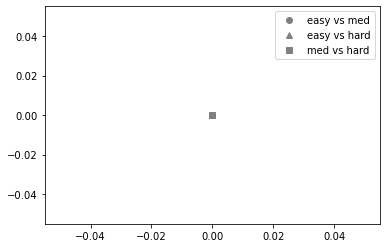

In [104]:
            
plt.figure()
for pvi in range(3):
    plt.plot(0,0, sig_shapes[pvi], color=[0.5, 0.5, 0.5])
plt.legend(['%s vs %s'%(trial_group_names[pair[0]], trial_group_names[pair[1]]) for pair in pairs_compare])


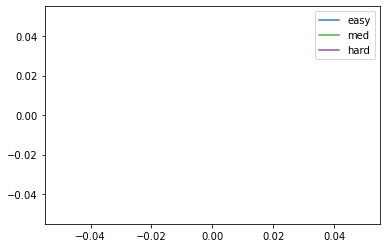

In [102]:
plt.figure()
for pvi in range(3):
    plt.plot(0,0, color=colors[ii])
plt.legend(['easy', 'med', 'hard'])

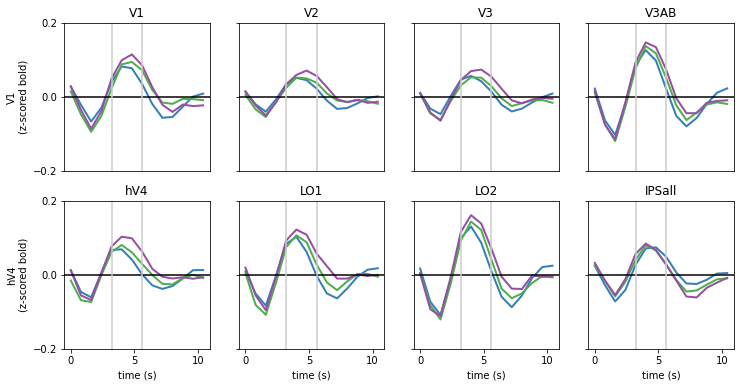

In [7]:
colors = cm.Set1(np.linspace(0,1,9))[[1,2,3],:]

n_rois = len(roi_names)

pi = 0;

plt.figure(figsize=(12,6))

# for ri in range(1):
for ri in range(n_rois):
    
    pi+=1
    plt.subplot(2,4,pi)


    dat1 = []
    dat2 = []
    dat3 = []

    for si in range(n_subjects):

        is_main_grid = np.array(replabs_all[si]['is_main_grid']==1)
        is_first = np.array(replabs_all[si]['is_first_in_run']==1)
        is_repeat = np.array(replabs_all[si]['is_repeat']==1)

        inds1 = is_main_grid & ~is_first
        inds2 = ~is_main_grid & ~is_first & ~is_repeat
        inds3 = ~is_main_grid & ~is_first & is_repeat

        # print(np.sum(inds1), np.sum(inds2), np.sum(inds3))

        d1 = np.mean(np.mean(repdat_all[si][ri][inds1,:,:], axis=0), axis=1)
        dat1.append(d1)

        d2 = np.mean(np.mean(repdat_all[si][ri][inds2,:,:], axis=0), axis=1)
        dat2.append(d2)

        d3 = np.mean(np.mean(repdat_all[si][ri][inds3,:,:], axis=0), axis=1)
        dat3.append(d3)

        dat1.append(d1)
        dat2.append(d2)
        dat3.append(d3)

    dat1 = np.array(dat1)
    dat2 = np.array(dat2)
    dat3 = np.array(dat3)

    # then average over subjects
    mean_vals1 = np.mean(dat1, axis=0)
    mean_vals2 = np.mean(dat2, axis=0)
    mean_vals3 = np.mean(dat3, axis=0)

    plt.plot(time_axis, mean_vals1, color=colors[0, :], lw = 2)
    plt.plot(time_axis, mean_vals2, color=colors[1, :], lw = 2)
    plt.plot(time_axis, mean_vals3, color=colors[2, :], lw = 2)

    # x = np.mean(time_axis[avgTRs_targ[0]:avgTRs_targ[1]])+ti*0.1
    # y = np.mean(mean_vals[avgTRs_targ[0]:avgTRs_targ[1]])
    # plt.plot(x,y,'o', color=task_colors[ti,:])


    plt.ylim([-0.2, 0.2])
    plt.axhline(0, color='k')

    plt.axvline(time_axis[avgTRs_targ[0]], color=[0.8, 0.8, 0.8])
    plt.axvline(time_axis[avgTRs_targ[1]], color=[0.8, 0.8, 0.8])

    plt.title(roi_names[ri])
    if ri>3:
        plt.xlabel('time (s)')
    else:
        plt.xticks([])

    if np.mod(ri,4)==0:
        plt.ylabel('%s\n(z-scored bold)'%roi_names[ri])
        plt.yticks([-0.2, 0, 0.2])
        
    else:
        plt.yticks([-0.2, 0, 0.2], [])
        

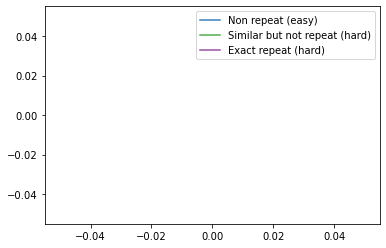

In [8]:
            
plt.figure()
for ii in range(3):
    plt.plot(0,0, color=colors[ii])
plt.legend(['Non repeat (easy)', 'Similar but not repeat (hard)', 'Exact repeat (hard)'])